In [339]:
# Cell 1: Imports
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


In [340]:
# Cell 2: Constants
G = 6.67430e-11     # Gravitational constant (m^3 kg^-1 s^-2)
c = 2.998e8         # Speed of light (m/s)
kB = 1.380649e-23   # Boltzmann constant (J/K)
M_sol = 2e30        # Solar mass (kg)
sigma = 5.67e-8     # Stefan-Boltzmann constant (W/m^2/K^4)
h = 6.626e-34       # Planck constant (J·s)


In [341]:
# Cell 3: Parameters (User-Adjustable)

# Black Hole and Accretion Parameters
M_BH = M_sol * 1e8  # Black hole mass (kg)
dot_M = 1.225e-7 * M_sol        # Accretion rate (kg/s) Calculated the correct accretion rate , initially half 

# Grid Setup
num_points = 1000               # Number of radial grid points
num_angular_sections = 100      # Number of angular grid points

# Radial Range Factors
R_in_factor = 6     # Inner radius factor (e.g., 6 for ISCO)
R_out_factor = 100  # Outer radius factor in terms of ISCO

# Time Setup
warm_up_time = 200          # Warm-up time (seconds)
total_simulation_time = 10000  # Total simulation time (seconds)
time_points = 1000       # Number of time points

# Flare Parameters
num_flares = 1000  # Number of flares

# Flare Temperature Increase Factors
flare_temp_increase_min = 1     # Minimum temperature increase factor
flare_temp_increase_max = 1.99  # Maximum temperature increase factor
flare_temp_increase_power_law_index = 1.5  # Power-law index

# Flare Durations
flare_rise_time_min = 10    # Minimum flare rise time (seconds)
flare_rise_time_max = 50    # Maximum flare rise time (seconds)
flare_e_folding_time_min = 20 # Minimum e-folding time (seconds)
flare_e_folding_time_max = 50  # Maximum e-folding time (seconds)
flare_decay_e_folding_multiplicator = 5   # Number of e-folding times in decay phase

# Flare Sizes (Radial and Angular)
min_flare_size_r = 1e9      # Minimum flare radial size (meters)
max_flare_size_r = 1e11     # Maximum flare radial size (meters)
min_flare_size_theta = np.pi / 100  # Minimum flare angular size (radians)
max_flare_size_theta = np.pi / 10   # Maximum flare angular size (radians)
flare_size_r_grid_multiplier = 10  # Minimum radial grid cells for flare size
flare_size_theta_grid_multiplier = 10  # Minimum angular grid cells for flare size


In [342]:
# Cell 4: Calculate ISCO Radius
def calculate_R_ISCO(M_BH):
    """
    Calculate ISCO radius for a non-rotating Black hole (meters)
    """
    return 6 * G * M_BH / c**2

R_ISCO = calculate_R_ISCO(M_BH)


In [343]:
# Cell 5: Radial and Angular Setup
R_in = R_in_factor * G * M_BH / c**2   # Inner radius (meters)
R_out = R_out_factor * R_ISCO          # Outer radius (meters)
R_disc= R_out 
print(np.log(R_ISCO))
print(R_disc/max_flare_size_r)
radii = np.linspace(R_in, R_out, num_points)   # Radial positions (meters)
dr = radii[1] - radii[0]                        # Radial grid spacing (meters)
dtheta = 2 * np.pi / num_angular_sections        # Angular grid spacing (radians)
theta_coords = np.linspace(0, 2 * np.pi, num_angular_sections, endpoint=False)  # Angular positions (radians)


27.515716203235016
891.094396486695


In [344]:
# Cell 6: Temperature Profile Function
def T_GR(R):
    """
    Computes the temperature profile T_GR(R) based on gravitational radius scaling.
    Ensures temperature is above a minimum threshold.
    """
    T_N4 = (3 * G * M_BH * dot_M) / (8 * np.pi * R**3 * sigma)
    T_eff = 1.1 * ((1 - (3 * G * M_BH) / (2 * R * c**2))**0.5) * np.maximum(T_N4, 1e-3)**0.25
    return T_eff


In [345]:
# Cell 7: Base Temperature Profile
temperature = T_GR(radii)
temperature = np.maximum(temperature, 273)  # Set minimum temperature to 273 K


In [346]:
# Cell 8: Time Grid
times = np.linspace(-warm_up_time, total_simulation_time, time_points)  # Time array (seconds)


In [347]:
# Cell 9: Initialize Fluctuating Temperature Array
fluctuating_temperature = np.zeros((num_points, num_angular_sections, len(times)), dtype=np.float32) 


In [348]:
# Cell 10: Flare Parameters Setup

# Flare Temperature Increases
temperature_increases = flare_temp_increase_min + (flare_temp_increase_max - flare_temp_increase_min) * np.random.power(a=flare_temp_increase_power_law_index, size=num_flares) 

# Randomly Assign Flare Times, Radii, and Angles
flare_times = np.random.choice(times, size=num_flares, replace=False)
flare_radii = np.random.choice(radii, size=num_flares, replace=True)
flare_angles = np.random.randint(0, num_angular_sections, size=num_flares)


In [349]:
# Cell 11: Flare Durations

# Flare Rise Times (seconds)
flare_rise_times = np.random.randint(flare_rise_time_min, flare_rise_time_max+1, size=num_flares)

# E-folding Times for Exponential Decay (seconds)
flare_e_folding_times = np.random.randint(flare_e_folding_time_min, flare_e_folding_time_max+1, size=num_flares)

# Decay Durations
flare_decay_times = flare_decay_e_folding_multiplicator * flare_e_folding_times

# Total Flare Durations
total_flare_durations = flare_rise_times + flare_decay_times


In [350]:
# Cell 12: Flare Sizes

# Flare Sizes in Physical Units
flare_size_r = np.random.uniform(min_flare_size_r, max_flare_size_r, size=num_flares)
flare_size_theta = np.random.uniform(min_flare_size_theta, max_flare_size_theta, size=num_flares)

# Ensure Flare Sizes are Larger Than Grid Spacing
flare_size_r = np.maximum(flare_size_r, flare_size_r_grid_multiplier * dr)
flare_size_theta = np.maximum(flare_size_theta, flare_size_theta_grid_multiplier * dtheta)


In [351]:
# Cell 13: Apply Flares to the Temperature Grid
for i in range(num_flares):
    flare_r = flare_radii[i]
    flare_theta = flare_angles[i] * dtheta
    flare_size_r_i = flare_size_r[i]
    flare_size_theta_i = flare_size_theta[i]
    
    # Time Indices
    t_start = np.argmin(np.abs(times - flare_times[i]))
    t_rise = flare_rise_times[i]
    t_decay = flare_decay_times[i]
    t_end = min(t_start + t_rise + t_decay, len(times))
    flare_time_indices = np.arange(t_start, t_end)
    
    # Time Since Flare Start
    time_since_start = times[flare_time_indices] - times[t_start]
    
    # Rising and Decay Phases
    rise_indices = time_since_start <= t_rise
    decay_indices = time_since_start > t_rise
    
    # Radial and Angular Indices
    r_indices = np.where(np.abs(radii - flare_r) <= flare_size_r_i / 2)[0]
    angular_diffs = np.abs(theta_coords - flare_theta)
    angular_diffs = np.minimum(angular_diffs, 2 * np.pi - angular_diffs)
    theta_indices = np.where(angular_diffs <= flare_size_theta_i / 2)[0]
    
    # Skip if No Cells are Affected
    if len(r_indices) == 0 or len(theta_indices) == 0:
        continue
    
    # Meshgrid of Affected Indices
    r_grid, theta_grid = np.meshgrid(r_indices, theta_indices, indexing='ij')
    
    # Temperature Increase Array
    delta_temperature_cells = np.zeros((len(r_indices), len(theta_indices), len(flare_time_indices)))
    
    # Rising Phase (Linear Rise)
    if np.any(rise_indices):
        rise_times = time_since_start[rise_indices]
        rise_fraction = rise_times / t_rise
        delta_temperature_rise = ((temperature_increases[i] - 1) * temperature[r_indices][:, np.newaxis, np.newaxis]) * rise_fraction[np.newaxis, np.newaxis, :]
        delta_temperature_cells[:, :, rise_indices] = delta_temperature_rise
    
    # Decay Phase (Exponential Decay)
    if np.any(decay_indices):
        decay_times = time_since_start[decay_indices] - t_rise
        tau = flare_e_folding_times[i]
        decay_fraction = np.exp(-decay_times / tau)
        delta_temperature_decay = ((temperature_increases[i] - 1) * temperature[r_indices][:, np.newaxis, np.newaxis]) * decay_fraction[np.newaxis, np.newaxis, :]
        delta_temperature_cells[:, :, decay_indices] = delta_temperature_decay
    
    # Update Fluctuating Temperature
    fluctuating_temperature[r_grid[:, :, np.newaxis], theta_grid[:, :, np.newaxis], flare_time_indices] += delta_temperature_cells


In [352]:
# Cell 14: Planck's Law Function
def planck_law(wavelength, temperature):
    """
    Computes the spectral radiance using Planck's Law.
    Args:
        wavelength (float or np.ndarray): Wavelength(s) in meters.
        temperature (np.ndarray): Temperature(s) in Kelvin.
    Returns:
        np.ndarray: Spectral radiance (W·m^-2·m^-1).
    """
    temperature = np.maximum(temperature, 1)  # Avoid division by zero
    exponent = (h * c) / (wavelength * kB * temperature)
    clipped_exponent = np.clip(exponent, -700, 700)  # Prevent overflow
    
    spectral_exitance = (2 * np.pi * h * c**2) / (wavelength**5 * (np.exp(clipped_exponent) - 1))
    spectral_exitance = np.nan_to_num(spectral_exitance, nan=0.0, posinf=0.0, neginf=0.0)
    
    return spectral_exitance


In [353]:
# Cell 15: Total Temperature
total_temperature = temperature[:, np.newaxis, np.newaxis] + fluctuating_temperature


In [354]:
# Cell 16: Wavelengths for Spectral Radiance Calculation
wavelengths = np.array([100e-9, 200e-9, 300e-9, 400e-9, 500e-9])  # 100 nm to 500 nm


In [355]:
# Cell 17: Compute Cell Areas
areas = (radii * dr * dtheta)[:, np.newaxis, np.newaxis]


In [356]:
# Cell 18: Initialize Luminosity Array
luminosity = np.zeros((len(wavelengths), len(times)), dtype=np.float64)


In [357]:
# Cell 19: Calculate Spectral Radiance and Luminosity
for idx, wavelength in enumerate(wavelengths):
    print(f"Processing wavelength: {int(wavelength*1e9)} nm")
    spectral_radiance = planck_law(wavelength, total_temperature)
    luminosity[idx, :] = np.sum(spectral_radiance * areas, axis=(0, 1))


Processing wavelength: 100 nm
Processing wavelength: 200 nm
Processing wavelength: 300 nm
Processing wavelength: 400 nm
Processing wavelength: 500 nm


In [358]:
# Cell 20: Compute Magnitudes Function
def compute_magnitudes(luminosity, times):
    """
    Computes magnitudes based on luminosity data.
    Args:
        luminosity (np.ndarray): Luminosity array (num_wavelengths, time_points).
        times (np.ndarray): Time array (seconds).
    Returns:
        np.ndarray: Magnitudes array (num_wavelengths, time_points).
    """
    sf_mask = times >= 0  
    filtered_times = times[sf_mask]
    filtered_luminosity = luminosity[:, sf_mask]
    
    L_mean = np.mean(filtered_luminosity, axis=1, keepdims=True)
    L_mean = np.maximum(L_mean, 1e-20)
    
    magnitudes = -2.5 * np.log10(filtered_luminosity / L_mean)
    
    return filtered_times, magnitudes


In [359]:
# Cell 21: Compute Magnitudes
filtered_times, magnitudes = compute_magnitudes(luminosity, times)


In [360]:
# Cell 22: Compute Color Indices Function
def compute_color_indices(magnitudes, wavelengths):
    """
    Computes color indices based on magnitude differences between consecutive wavelengths.
    Args:
        magnitudes (np.ndarray): Magnitudes array (num_wavelengths, time_points).
        wavelengths (np.ndarray): Wavelengths array (meters).
    Returns:
        dict: Dictionary of color indices with keys as wavelength pairs.
    """
    colors = {}
    for i in range(len(wavelengths) - 1):
        mag1 = magnitudes[i, :]
        mag2 = magnitudes[i + 1, :]
        color_index = mag1 - mag2
        colors[f"{int(wavelengths[i]*1e9)}-{int(wavelengths[i+1]*1e9)} nm"] = color_index
    return colors


In [361]:
# Cell 23: Compute Color Indices
colors = compute_color_indices(magnitudes, wavelengths)


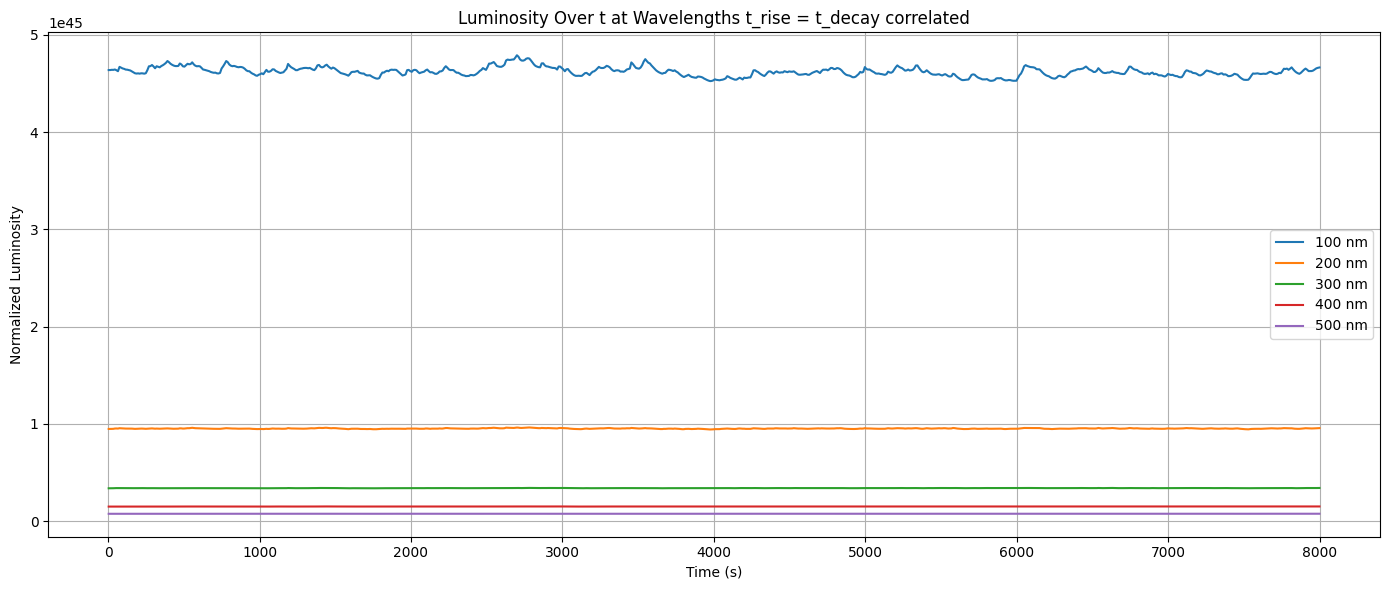

In [370]:
# Cell 24: Plot Normalized Luminosity Over Time
start_time = 1   # Start time in seconds
end_time = 8000     # End time in seconds

plt.figure(figsize=(14, 6))

for i, wavelength in enumerate(wavelengths):
    # Extract luminosity after warm-up period
    luminosity_i = luminosity[i, times >= 0]
    
    # Corresponding filtered times after warm-up
    times_i = times[times >= 0]
    
    # Create a mask for the desired time range
    mask = (times_i >= start_time) & (times_i <= end_time)
    
    # Apply the mask to luminosity and times
    luminosity_subset = luminosity_i[mask]
    times_subset = times_i[mask]
    
    # Check if there are any data points in the specified range
    if len(luminosity_subset) == 0:
        print(f"No data available for wavelength {int(wavelength*1e9)} nm in the specified time range.")
        continue
    
    # Normalize luminosity so that the initial value in the subset is 1
    luminosity_normalized = luminosity_subset / luminosity_subset[0]
    
    # Plot the normalized luminosity
    plt.plot(times_subset, luminosity_subset, label=f'{int(wavelength*1e9)} nm')

plt.xlabel('Time (s)')
#plt.yscale('log')
plt.ylabel('Normalized Luminosity')
plt.title('Luminosity Over t at Wavelengths t_rise = t_decay correlated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


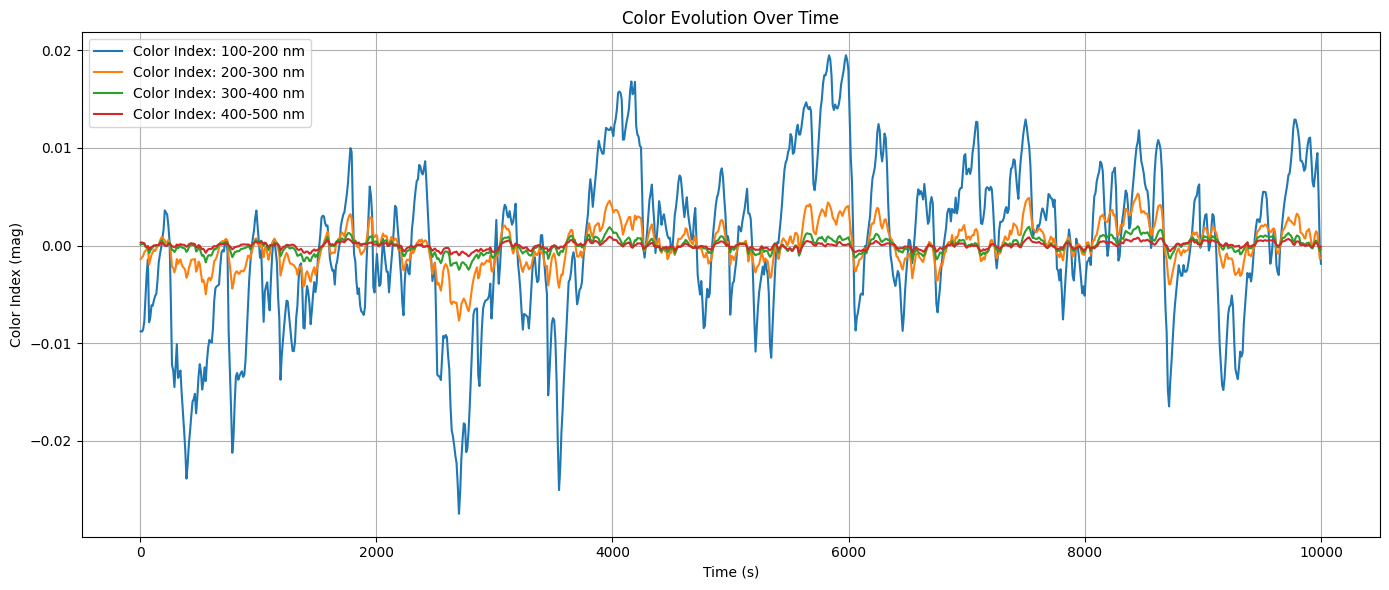

In [371]:
# Cell 25: Plot Color Indices Over Time
plt.figure(figsize=(14, 6))
for color_label, color_data in colors.items():
    plt.plot(filtered_times, color_data, label=f'Color Index: {color_label}')
plt.xlabel('Time (s)')
plt.ylabel('Color Index (mag)')
plt.title('Color Evolution Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [372]:
import numpy as np
import matplotlib.pyplot as plt

def compute_normalized_structure_function(magnitude_data, times, num_bins=50):
    """
    Computes the normalized structure function for a given magnitude data without downsampling.
    
    Args:
        magnitude_data (np.ndarray): Magnitude data (time_points,).
        times (np.ndarray): Time array corresponding to magnitude_data (seconds).
        num_bins (int): Number of bins for time lags.
    
    Returns:
        tuple: (lag_bin_centers, normalized_structure_function)
    """
    # Ensure there are enough data points
    if len(times) < 2:
        raise ValueError("Insufficient data points to compute the structure function.")
    
    # **Sort the times and magnitude data**
    sorted_indices = np.argsort(times)
    times_sorted = times[sorted_indices]
    magnitude_sorted = magnitude_data[sorted_indices]
    
    # Compute time differences and magnitude differences
    time_diffs = np.subtract.outer(times_sorted, times_sorted)  # Shape: (N, N)
    mag_diffs = np.subtract.outer(magnitude_sorted, magnitude_sorted)  # Shape: (N, N)
    
    # Use only positive time lags
    mask = time_diffs > 0
    time_lags = time_diffs[mask]
    mag_diffs_squared = mag_diffs[mask] ** 2
    
    # Check if there are any positive time lags
    if len(time_lags) == 0:
        raise ValueError("No positive time lags found in the data.")
    
    # Define lag bins (logarithmic spacing)
    lag_bins = np.logspace(np.log10(np.min(time_lags)), np.log10(np.max(time_lags)), num_bins)
    
    # Initialize structure function array
    sf = np.zeros(len(lag_bins) - 1)
    
    # Compute structure function
    for i in range(len(lag_bins) - 1):
        bin_mask = (time_lags >= lag_bins[i]) & (time_lags < lag_bins[i + 1])
        if np.sum(bin_mask) > 0:
            sf[i] = np.mean(mag_diffs_squared[bin_mask])
        else:
            sf[i] = np.nan  # Assign NaN if no data points in the bin
    
    # Normalize the structure function by the variance of the magnitude data
    variance_mag = np.var(magnitude_sorted)
    if variance_mag == 0:
        raise ValueError("Variance of magnitude data is zero; cannot normalize structure function.")
    
    sf_normalized = sf / variance_mag
    
    # Compute lag bin centers for plotting
    lag_bin_centers = np.sqrt(lag_bins[:-1] * lag_bins[1:])
    
    return lag_bin_centers,sf





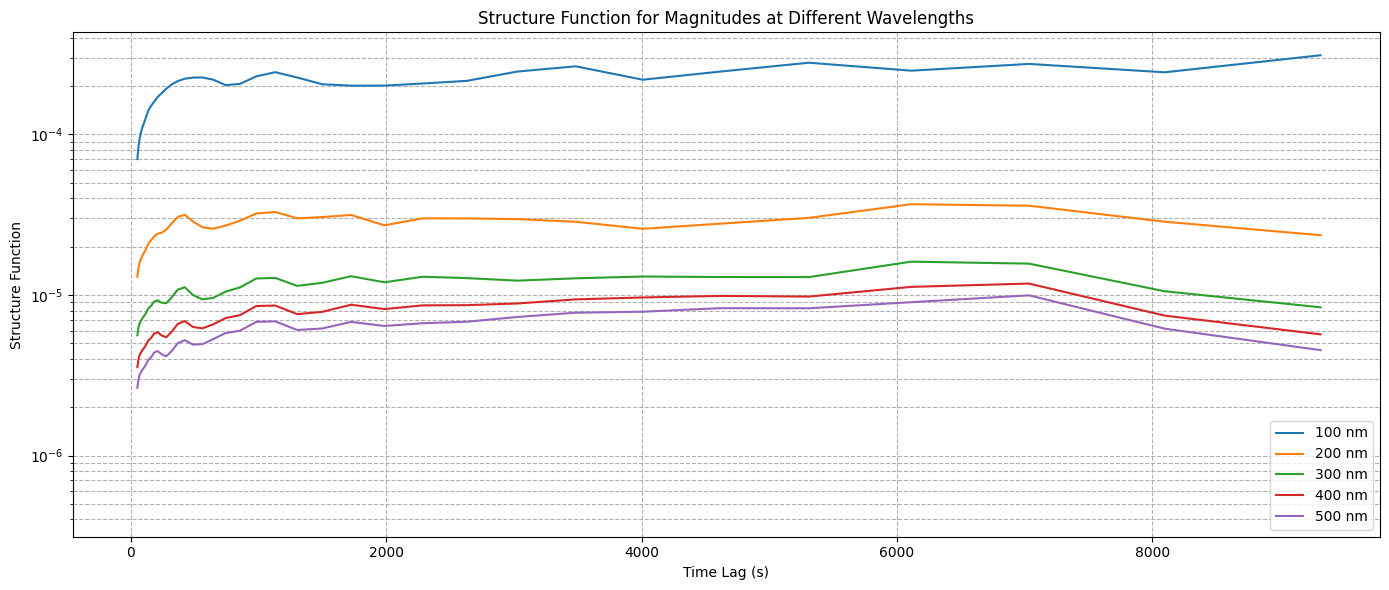

In [373]:
# Cell 27: Plot Normalized Structure Function for All Wavelengths

plt.figure(figsize=(14, 6))


for idx, wavelength in enumerate(wavelengths):
    lag_bins,sf_normalized  = compute_normalized_structure_function(magnitudes[idx, :], filtered_times)
    #print(type(sf_normalized))
    plt.plot(lag_bins, sf_normalized, label=f'{int(wavelength*1e9)} nm')
    

#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time Lag (s)')
plt.ylabel('Structure Function')
plt.title('Structure Function for Magnitudes at Different Wavelengths')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


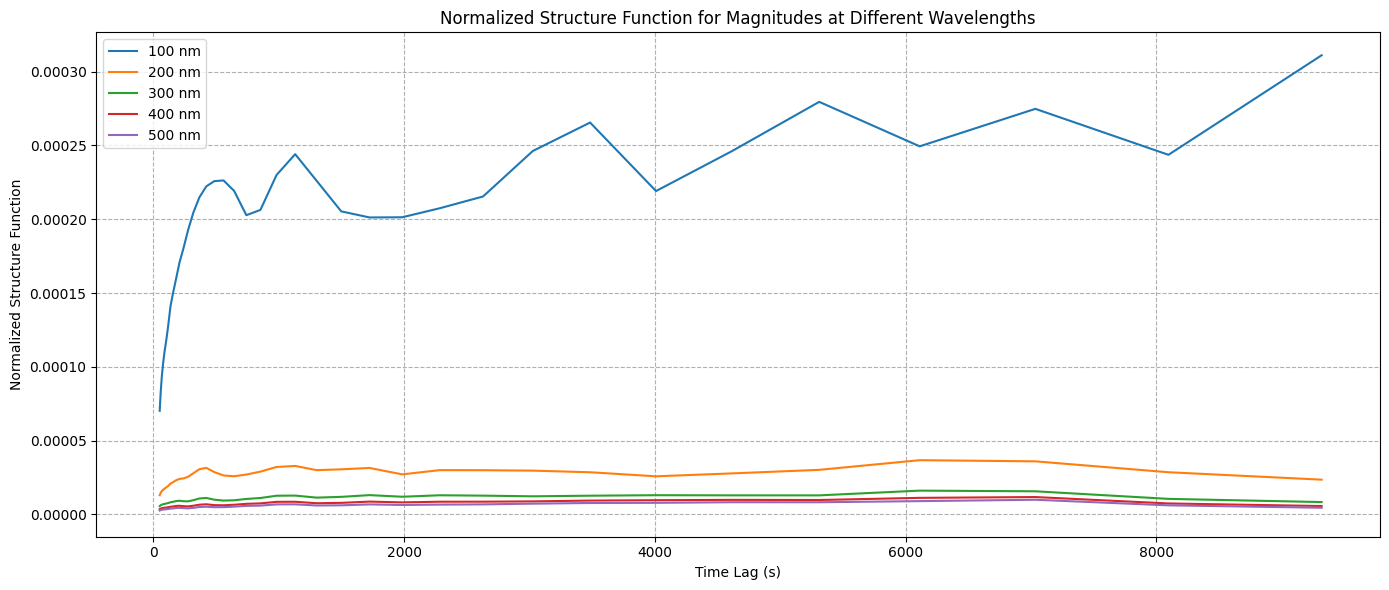

In [374]:
# Cell 27: Plot Normalized Structure Function for All Wavelengths

plt.figure(figsize=(14, 6))


for idx, wavelength in enumerate(wavelengths):
    lag_bins, sf_normalized = compute_normalized_structure_function(magnitudes[idx, :], filtered_times)
    #print(type(sf_normalized))
    plt.plot(lag_bins, sf_normalized, label=f'{int(wavelength*1e9)} nm')
    

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Time Lag (s)')
plt.ylabel('Normalized Structure Function')
plt.title('Normalized Structure Function for Magnitudes at Different Wavelengths')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


In [367]:
# Cell 28: Visualize Sample Flare Function (Optional)
def visualize_sample_flare(i=1):
    """
    Visualizes the temperature evolution of a sample flare.
    Args:
        i (int): Index of the flare to visualize.
    """
    if i >= num_flares:
        print(f"Flare index {i} is out of range.")
        return
    
    flare_r = flare_radii[i]
    flare_theta = flare_angles[i] * dtheta
    flare_size_r_i = flare_size_r[i]
    flare_size_theta_i = flare_size_theta[i]
    t_start = np.argmin(np.abs(times - flare_times[i]))
    t_rise = flare_rise_times[i]
    t_decay = flare_decay_times[i]
    t_end = min(t_start + t_rise + t_decay, len(times))
    flare_time_indices = np.arange(t_start, t_end)
    
    # Find Radial and Angular Indices
    r_indices = np.where(np.abs(radii - flare_r) <= flare_size_r_i / 2)[0]
    angular_diffs = np.abs(theta_coords - flare_theta)
    angular_diffs = np.minimum(angular_diffs, 2 * np.pi - angular_diffs)
    theta_indices = np.where(angular_diffs <= flare_size_theta_i / 2)[0]
    
    if len(r_indices) == 0 or len(theta_indices) == 0:
        print("No cells affected by this flare.")
        return
    
    # Sample Cell for Visualization
    sample_r = r_indices[0]
    sample_theta = theta_indices[0]
    
    # Extract Temperature Changes
    temp_change = fluctuating_temperature[sample_r, sample_theta, flare_time_indices]
    base_temp = temperature[sample_r]
    total_temp = base_temp + temp_change
    print(flare_rise_times[i])
    # Plot Temperature Over Time
    plt.figure(figsize=(10, 6))
    plt.plot(times[flare_time_indices], total_temp, label='Total Temperature')
    plt.axvline(x=times[t_start], color='r', linestyle=':', label='Flare Start')
    plt.axvline(x=times[t_end-1], color='g', linestyle=':', label='Flare End')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.title(f'Sample Flare {i} Temperature Evolution at r={flare_r:.2e} m, θ={flare_theta:.2f} rad')
    plt.legend()
    plt.grid(True)
    plt.show()


39


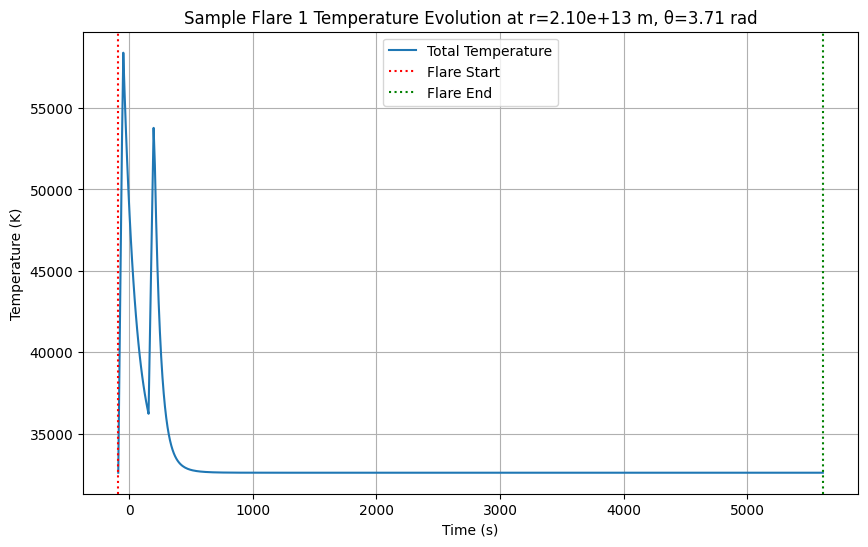

In [368]:
# Cell 29: Visualize a Sample Flare
visualize_sample_flare()


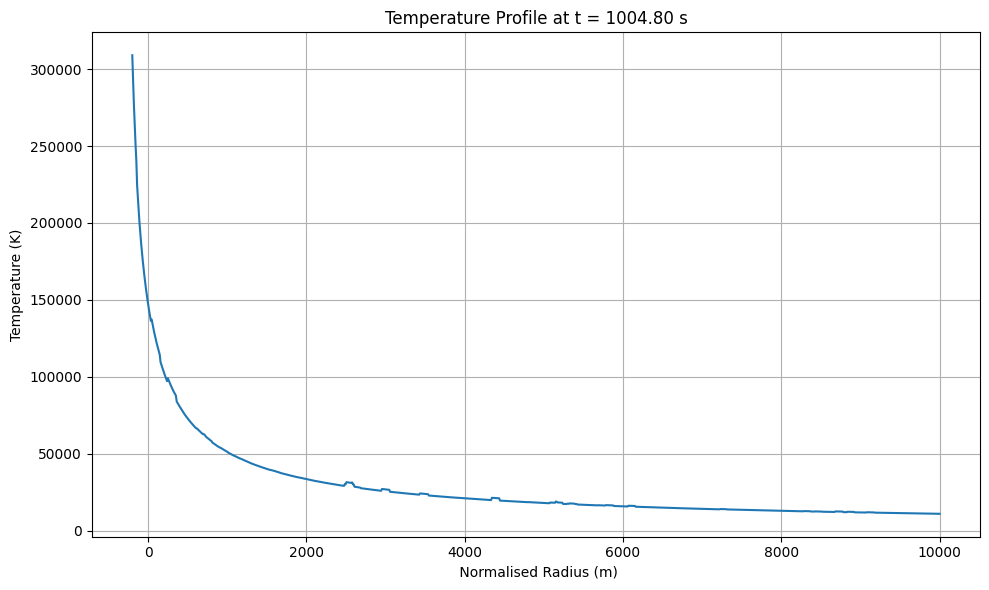

In [369]:
# Cell 30: Plot Temperature Profile at a Specific Time

def plot_temperature_profile_at_time(specific_time):
    """
    Plots the temperature profile of the accretion disk at a specific time.
    
    Args:
        specific_time (float): The time at which to plot the temperature profile (seconds).
    """
    # Ensure the specific time is within the simulation time range
    if specific_time < times[0] or specific_time > times[-1]:
        print(f"Time {specific_time} s is outside the simulation range ({times[0]} s to {times[-1]} s).")
        return
    
    # Find the index of the closest time to the specific_time
    time_index = np.argmin(np.abs(times - specific_time))
    actual_time = times[time_index]
    
    # Extract temperature data at the specific time
    temperature_at_time = total_temperature[:, :, time_index]  # Shape: (num_points, num_angular_sections)
    
    # Average over theta to get temperature as a function of radius
    temperature_profile = np.mean(temperature_at_time, axis=1)  # Shape: (num_points,)
    radii_norm = radii/np.max(radii)

    # Plot temperature profile
    plt.figure(figsize=(10, 6))
    plt.plot(times, temperature_profile)
    #plt.xscale('log')
    plt.xlabel(' Normalised Radius (m)')
    plt.ylabel('Temperature (K)')
    plt.title(f'Temperature Profile at t = {actual_time:.2f} s')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# You can specify any time within your simulation range
plot_temperature_profile_at_time(specific_time=1006)  # Replace  with desired time in seconds


Changes in the code :
- Normalised strucutre function
- Figure out how Time resolution is affecting the MATH
- Scale flares according to the disc size 
- For impulse flares , minimum random operator 
- Check variability perecentage from mean value , should be around 10-20 % 
- Temperature profile , radius normalise 
- T_rise T_decay problem